In [13]:
import os
import sys
sys.path.insert(0, '../src/')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pm4py
import data_importer
import graphviz_helper
import footprint_analyzer
import mercury as mr
import warnings
from IPython.display import display, Markdown
from datetime import timedelta

input_path = "../data"
data_file = "test_data.csv"

In [14]:
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [15]:
pg_df = data_importer.import_data(input_path, data_file)
pg_df = data_importer.filter_na(pg_df)

# Convert "Downtime Actual" to timedelta
pg_df['Malfunction Duration'] = pd.to_timedelta(pg_df['Downtime Actual'])

# Calculate the "Lead Time" column by converting "Processing Duration Actual" to timedelta
pg_df['Lead Time'] = pd.to_timedelta(pg_df['Processing Duration Actual'])

pg_df.rename(columns={'Scrap Quantity Actual (Recording Unit)': 'Rejected Materials'}, inplace=True)
pg_df.rename(columns={'Created On (Contract)': 'Created At'}, inplace=True)

# Calculate the "OEE" column as a product of "Availability", "Performance", "Quality"
pg_df['OEE'] = pg_df['Availability'] * pg_df['Performance'] * pg_df['Quality']

ValueError: Usecols do not match columns, columns expected but not found: ['Order', 'Created On (Order)']

In [ ]:
kpi = mr.Select(label="Select a KPI", value='Lead Time', choices=['OEE', 'Lead Time', 'Malfunction Duration', 'Rejected Materials'])

mercury.Select

In [ ]:
time_period = mr.Select(label="Select a time period", value='Last 2 Weeks', choices=['Last 2 Weeks', 'Last Month', 'Last 3 Months', 'Entire period'])

mercury.Select

In [ ]:
newest_arbeitsgangs = pg_df.sort_values(by='End Date Actual', ascending=False)
current_date = newest_arbeitsgangs.head(1)['End Date Actual'].iloc[0]

if time_period.value == 'Last 2 Weeks':
    two_weeks_ago = current_date - timedelta(weeks=2)
    newest_arbeitsgangs = newest_arbeitsgangs[newest_arbeitsgangs['End Date Actual'] >= two_weeks_ago]
elif time_period.value == 'Last Month':
    month_ago = current_date - timedelta(weeks=4)
    newest_arbeitsgangs = newest_arbeitsgangs[newest_arbeitsgangs['End Date Actual'] >= month_ago]
elif time_period.value == 'Last 3 Months':
    three_months_ago = current_date - timedelta(weeks=12)
    newest_arbeitsgangs = newest_arbeitsgangs[newest_arbeitsgangs['End Date Actual'] >= three_months_ago]

In [ ]:
materialnumbers = newest_arbeitsgangs['Material Number'].unique()
materialnumbers_choices = ['All'] + materialnumbers.tolist()
materialnumber = mr.Select(label="Select a material number", value='All', choices=materialnumbers_choices)

mercury.Select

In [ ]:
# Calculate the KPIs for each materialnumber
kpis_mnr = {}
kpis_mnr['label'] = []
kpis_mnr['OEE'] = []
kpis_mnr['Lead Time'] = []
kpis_mnr['Malfunction Duration'] = []
kpis_mnr['Rejected Materials'] = []

for mnr in materialnumbers:
    kpis_mnr[mnr] = footprint_analyzer.extract_kpi_information(newest_arbeitsgangs.loc[newest_arbeitsgangs["Material Number"] == mnr])
    kpis_mnr['label'].append(str(mnr))
    kpis_mnr['OEE'].append(kpis_mnr[mnr]['OEE'].iloc[0])
    kpis_mnr['Lead Time'].append(kpis_mnr[mnr]['Lead Time'].iloc[0])
    kpis_mnr['Malfunction Duration'].append(kpis_mnr[mnr]['Malfunction Duration'].iloc[0])
    kpis_mnr['Rejected Materials'].append(kpis_mnr[mnr]['Rejected Materials'].iloc[0])

## A scatterplot of all material numbers in the Last 2 Weeks for the selected KPI

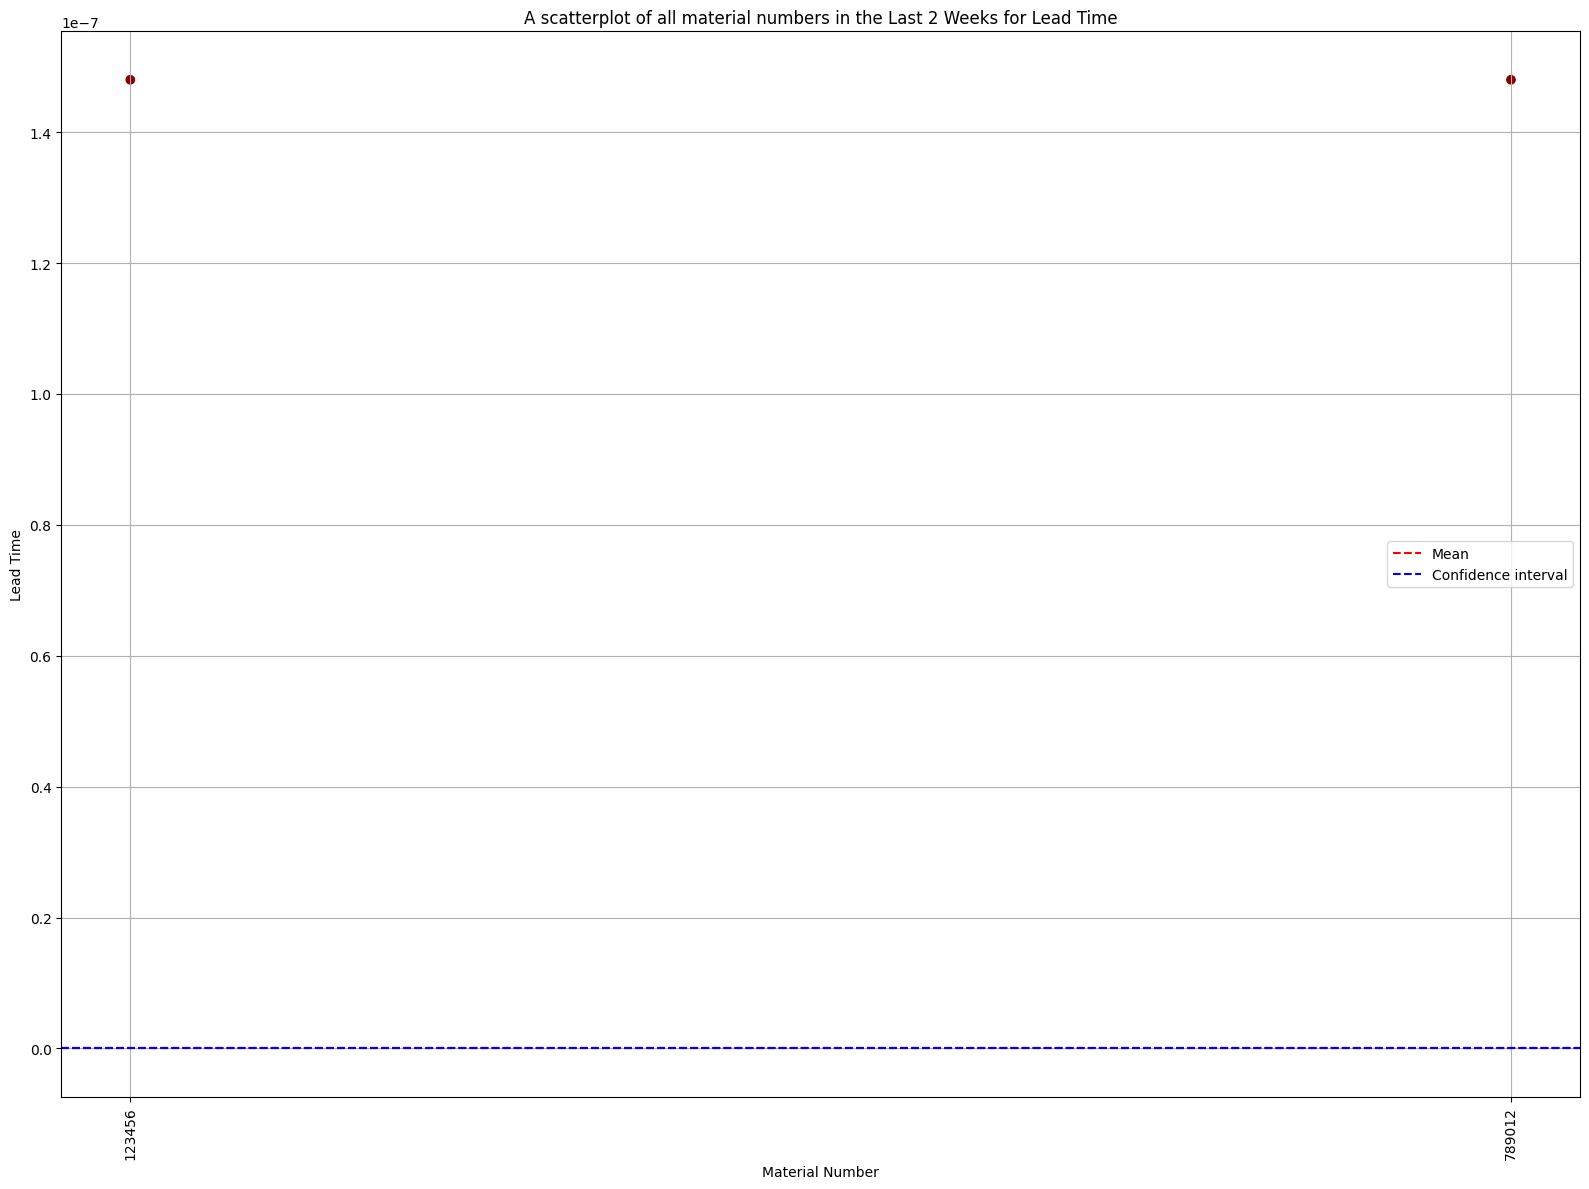

In [ ]:
if materialnumber.value == 'All':
    kpi_means = footprint_analyzer.calcualte_kpi_means(pg_df)
    kpi_sds = footprint_analyzer.calculate_sds(kpis_mnr)

    display(Markdown(f'## A scatterplot of all material numbers in the {time_period.value} for the selected KPI'))
    footprint_analyzer.draw_footprint_kpi_scatter(kpis_mnr['label'], kpis_mnr[kpi.value], kpi_means[kpi.value], kpi_sds[kpi.value], f'A scatterplot of all material numbers in the {time_period.value} for {kpi.value}', 'Material Number', kpi.value)
else:
    # Filter the data by materialnummer
    filtered_pg_df = pg_df.loc[pg_df["Material Number"] == materialnumber.value]
    analyse_mode = mr.Select(label="Select analysis mode", value='Footprints', choices=['Footprints'])
    auftraege = filtered_pg_df['Contract'].unique()
    kpi_means = footprint_analyzer.calcualte_kpi_means(filtered_pg_df)

    if analyse_mode.value == 'Footprints':

        # Analyze the footprints
        fp_kpis, fp_auftrags, diff_to_soll = footprint_analyzer.analyze_footprints_by_kpi(filtered_pg_df, auftraege, kpis_mnr[materialnumber.value])
        kpi_sds = footprint_analyzer.calculate_sds(fp_kpis)

        # Analyze the outliers
        outlier_fps, outlier_colors = footprint_analyzer.calculate_outlier_footprints(
            fp_kpis['fp'], fp_kpis[kpi.value], kpi_means[kpi.value], kpi_sds[kpi.value], kpi.value)

        edge_markings = footprint_analyzer.extract_edge_markings(outlier_fps, outlier_colors)

        outlier_fps_for_dropdown = {'label': ['None', 'All'], 'value': [None, None]}
        fp_dropdown_mapping = {}

        for ofp in outlier_fps:
            outlier_fps_for_dropdown['label'].append(ofp[0] + ' -> ' + ofp[1])
            outlier_fps_for_dropdown['value'].append(ofp)
            fp_dropdown_mapping[ofp[0] + ' -> ' + ofp[1]] = ofp

        # Plot the DFG for the chosen footprint
        outlier_footprint = mr.Select(label="Select an outlier footprint", value='None', choices=outlier_fps_for_dropdown['label'])
        if outlier_footprint.value == 'All':
            time = 'End Date Actual'
            activity = 'Operation RelNr'
            case_id = 'Contract'
            
            curr = filtered_pg_df.loc[filtered_pg_df['End Date Actual'].notna()]
            curr = curr.rename(columns={time: 'time:timestamp', case_id: 'case:concept:name', activity: 'concept:name'})

            all_dfg = pm4py.discover_dfg(curr)

            display(Markdown('## A DFG for all contracts'))
            display(Markdown('### The outlier footprints have been marked'))
            graphviz_helper.view_graphviz_dfg(all_dfg, edge_markings)
        elif outlier_footprint.value == 'None':
            # Plot the footprints
            display(Markdown('## A scatterplot of all footprints for the selected KPI'))
            footprint_analyzer.draw_footprint_kpi_scatter(fp_kpis['label'], fp_kpis[kpi.value], kpi_means[kpi.value], kpi_sds[kpi.value], f'A scatter plot of {kpi.value} over all footprints for the material number = {materialnumber.value}', 'Footprint', kpi.value)
        else:
            chosen_fp = fp_dropdown_mapping[outlier_footprint.value]

            display(Markdown('## A DFG for contracts with the selected footprint'))
            display(Markdown('### The outlier footprints have been marked'))
            footprint_analyzer.draw_dfg_for_footprint(filtered_pg_df, fp_auftrags[chosen_fp], edge_markings)

        # Print the analysis details
        kpis_mnr_pd = pd.DataFrame(kpis_mnr[materialnumber.value])
        kpis_mnr_pd = kpis_mnr_pd.drop(columns=['Contract'])
        kpis_mnr_pd = kpis_mnr_pd.round(2)
        display(Markdown('## KPI values for a material number'))
        display(kpis_mnr_pd)

        analysis_df = pd.DataFrame(data=fp_kpis)
        analysis_df = analysis_df.drop(columns=['fp'])
        analysis_df = analysis_df.rename(columns={'label': 'Footprint'})
        analysis_df = analysis_df.round(2)
        display(Markdown('## KPI values by footprint'))
        display(analysis_df)

        analysis_df_comp_to_soll = pd.DataFrame(diff_to_soll)
        analysis_df_comp_to_soll = analysis_df_comp_to_soll.round(2)
        display(Markdown('## Comparison of KPI values per footprint with target'))
        display(analysis_df_comp_to_soll)